In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import cv2

# Define paths to the dataset folders
train_dir = './dataset/Train/'
test_dir = './dataset/Test/'
valid_dir = './dataset/Validation/'

# Define image size for MobileNet
img_size = (224, 224)
batch_size = 32

# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load MobileNet model with pre-trained weights (excluding top layer)
base_model = MobileNet(
    include_top=False,
    input_shape=(224, 224, 3)
)

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)  # 3 classes: mask, no mask, improper mask

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])




Found 2400 images belonging to 3 classes.
Found 390 images belonging to 3 classes.
Found 1140 images belonging to 3 classes.


In [2]:
# Train the model
epochs = 10
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=valid_generator
)

Epoch 1/10
75/75 [==============================] - 78s 998ms/step - loss: 0.3005 - accuracy: 0.8950 - val_loss: 0.6643 - val_accuracy: 0.7564
Epoch 2/10
75/75 [==============================] - 77s 1s/step - loss: 0.0861 - accuracy: 0.9658 - val_loss: 0.5205 - val_accuracy: 0.8103
Epoch 3/10
75/75 [==============================] - 78s 1s/step - loss: 0.0802 - accuracy: 0.9712 - val_loss: 0.5252 - val_accuracy: 0.8231
Epoch 4/10
75/75 [==============================] - 69s 912ms/step - loss: 0.1164 - accuracy: 0.9592 - val_loss: 0.4276 - val_accuracy: 0.8538
Epoch 5/10
75/75 [==============================] - 84s 1s/step - loss: 0.0805 - accuracy: 0.9712 - val_loss: 0.4672 - val_accuracy: 0.8179
Epoch 6/10
75/75 [==============================] - 91s 1s/step - loss: 0.0636 - accuracy: 0.9762 - val_loss: 0.4569 - val_accuracy: 0.8333
Epoch 7/10
75/75 [==============================] - 96s 1s/step - loss: 0.0430 - accuracy: 0.9846 - val_loss: 0.5248 - val_accuracy: 0.8256
Epoch 8/10
75/

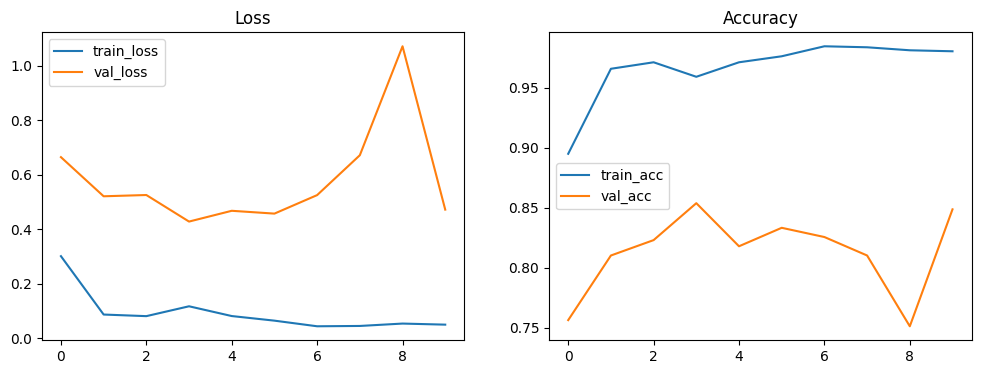

In [3]:

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title('Accuracy')

plt.show()

model.save('mask_detection_mobile2.h5')


In [6]:

# Real-time mask detection using the trained model and camera
model.load_weights('mask_detection_mobile2.h5')  # Load the saved model weights

# Initialize camera
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    resized_frame = cv2.resize(frame, img_size)
    normalized_frame = resized_frame / 255.0
    
    prediction = model.predict(np.expand_dims(normalized_frame, axis=0))
    class_idx = np.argmax(prediction)
    
    if class_idx == 0:
        label = 'No Mask'
    elif class_idx == 1:
        label = 'Mask'
    else:
        label = 'Improper Mask'
    
    cv2.putText(frame, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow('Mask Detection', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 48ms/step
